# 1. Parameters

In [1]:
metadata_file = 'input/metadata.tsv.gz'
input_sequences = 'input/sequences.fasta.xz'
sequences_split_dir = 'input/split'
sequences_subset_all = 'input/all.fasta.gz'
subset_input_files_path = 'input/input-files.tsv'
subset_metadata_path = 'input/metadata-subsample.tsv'

subsample_number = 100000

# I can handle any amount of missing data in my index but building trees with iqtree starts to fail 
# when there is too much missing data so I'm limiting it here.
max_missing_percent = 50

sample_seed = 21561

In [2]:
from pathlib import Path

metadata_file = Path(metadata_file)
input_sequences = Path(input_sequences)
sequences_split_dir = Path(sequences_split_dir)
subset_input_files_path = Path(subset_input_files_path)
subset_metadata_path = Path(subset_metadata_path)
sequences_subset_all = Path(sequences_subset_all)

# 2. Load metadata

In [3]:
import pandas as pd

metadata_all_df = pd.read_csv(metadata_file, sep='\t')
metadata_all_df

/home/CSCScience.ca/apetkau/miniconda3/envs/gdi-sars-cov-2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4,5,9,38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,missing_data,divergence,nonACGTN,rare_mutations,snp_clusters,QC_missing_data,QC_mixed_sites,QC_rare_mutations,QC_snp_clusters,clock_deviation
0,ARG/Cordoba-1006-155/2020,ncov,?,MW553298,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,0.0,13.0,0.0,8.0,0.0,good,good,good,good,5.0
1,ARG/Cordoba-1083-6/2020,ncov,?,MW553296,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,0.0,14.0,0.0,9.0,0.0,good,good,good,good,6.0
2,ARG/Cordoba-11300-61/2020,ncov,?,MW553301,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,392.0,11.0,0.0,6.0,0.0,good,good,good,good,3.0
3,ARG/Cordoba-11301-61/2020,ncov,?,MW553314,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,0.0,13.0,0.0,8.0,0.0,good,good,good,good,5.0
4,ARG/Cordoba-11419-61/2020,ncov,?,MW553297,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,0.0,13.0,0.0,8.0,0.0,good,good,good,good,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095212,mink/NED/NB02_index/2020,ncov,EPI_ISL_447631,MT457398,NaN,2020-04-25,Europe,Netherlands,Netherlands,NaN,...,0.0,12.0,0.0,11.0,0.0,good,good,good,good,7.0
1095213,mink/NED/NB03_index/2020,ncov,EPI_ISL_447633,MT457400,NaN,2020-05-06,Europe,Netherlands,Netherlands,NaN,...,0.0,13.0,0.0,9.0,0.0,good,good,good,good,6.0
1095214,mink/NED/NB04_index/2020,ncov,EPI_ISL_447634,MT457401,NaN,2020-05-06,Europe,Netherlands,Netherlands,NaN,...,0.0,15.0,0.0,12.0,0.0,good,good,good,good,8.0
1095215,mink/NLD/1/2020,ncov,EPI_ISL_431778,MT396266,NaN,2020-04-24,Europe,Netherlands,North Brabant,Milheeze,...,0.0,9.0,0.0,5.0,0.0,good,good,good,good,3.0


In [4]:
metadata_all_df.columns

Index(['strain', 'virus', 'gisaid_epi_isl', 'genbank_accession',
       'sra_accession', 'date', 'region', 'country', 'division', 'location',
       'region_exposure', 'country_exposure', 'division_exposure', 'segment',
       'length', 'host', 'age', 'sex', 'Nextstrain_clade', 'pango_lineage',
       'GISAID_clade', 'originating_lab', 'submitting_lab', 'authors', 'url',
       'title', 'paper_url', 'date_submitted', 'sampling_strategy',
       'missing_data', 'divergence', 'nonACGTN', 'rare_mutations',
       'snp_clusters', 'QC_missing_data', 'QC_mixed_sites',
       'QC_rare_mutations', 'QC_snp_clusters', 'clock_deviation'],
      dtype='object')

## 2.1. Remove sequences with too high of missing data

<AxesSubplot:>

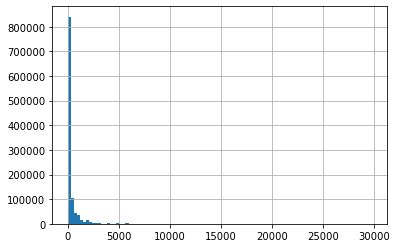

In [5]:
metadata_all_df['missing_data'].hist(bins=100)

<AxesSubplot:>

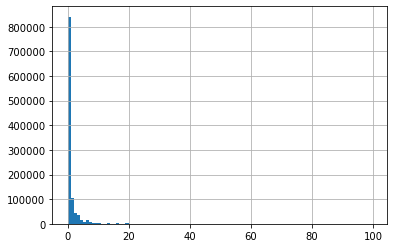

In [6]:
metadata_all_df['missing_data_percent'] = 100 * (metadata_all_df['missing_data'] / 29903)
metadata_all_df['missing_data_percent'].hist(bins=100)

In [7]:
metadata_all_df = metadata_all_df[metadata_all_df['missing_data_percent'] < max_missing_percent]
metadata_all_df

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,divergence,nonACGTN,rare_mutations,snp_clusters,QC_missing_data,QC_mixed_sites,QC_rare_mutations,QC_snp_clusters,clock_deviation,missing_data_percent
0,ARG/Cordoba-1006-155/2020,ncov,?,MW553298,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,13.0,0.0,8.0,0.0,good,good,good,good,5.0,0.000000
1,ARG/Cordoba-1083-6/2020,ncov,?,MW553296,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,14.0,0.0,9.0,0.0,good,good,good,good,6.0,0.000000
2,ARG/Cordoba-11300-61/2020,ncov,?,MW553301,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,11.0,0.0,6.0,0.0,good,good,good,good,3.0,1.310905
3,ARG/Cordoba-11301-61/2020,ncov,?,MW553314,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,13.0,0.0,8.0,0.0,good,good,good,good,5.0,0.000000
4,ARG/Cordoba-11419-61/2020,ncov,?,MW553297,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,13.0,0.0,8.0,0.0,good,good,good,good,5.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095212,mink/NED/NB02_index/2020,ncov,EPI_ISL_447631,MT457398,NaN,2020-04-25,Europe,Netherlands,Netherlands,NaN,...,12.0,0.0,11.0,0.0,good,good,good,good,7.0,0.000000
1095213,mink/NED/NB03_index/2020,ncov,EPI_ISL_447633,MT457400,NaN,2020-05-06,Europe,Netherlands,Netherlands,NaN,...,13.0,0.0,9.0,0.0,good,good,good,good,6.0,0.000000
1095214,mink/NED/NB04_index/2020,ncov,EPI_ISL_447634,MT457401,NaN,2020-05-06,Europe,Netherlands,Netherlands,NaN,...,15.0,0.0,12.0,0.0,good,good,good,good,8.0,0.000000
1095215,mink/NLD/1/2020,ncov,EPI_ISL_431778,MT396266,NaN,2020-04-24,Europe,Netherlands,North Brabant,Milheeze,...,9.0,0.0,5.0,0.0,good,good,good,good,3.0,0.000000


## 2.2. Look for duplicates in table

In [8]:
len_all = len(metadata_all_df)
len_no_duplicates = metadata_all_df['strain'].agg('count')
if len_all == len_no_duplicates:
    print(f'No duplicates: len_all={len_all} == len_no_duplicates={len_no_duplicates}')
else:
    print(f'Some duplicates found: len_all={len_all} == len_no_duplicates={len_no_duplicates}')

No duplicates: len_all=1094579 == len_no_duplicates=1094579


## 2.3. Subsample dataframe

In [9]:
metadata_df = metadata_all_df.sample(subsample_number, random_state=sample_seed)
metadata_df

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,divergence,nonACGTN,rare_mutations,snp_clusters,QC_missing_data,QC_mixed_sites,QC_rare_mutations,QC_snp_clusters,clock_deviation,missing_data_percent
554876,OU420663,ncov,?,OU420663,ERR5939958,2020,Europe,United Kingdom,England,NaN,...,40.0,0.0,15.0,0.0,good,good,good,good,?,0.351135
955389,USA/NY-CUIMC-NP-3606/2020,ncov,?,MZ702266,NaN,2020-12-02,North America,USA,New York,New York City,...,21.0,0.0,7.0,0.0,mediocre,good,good,good,0.0,4.417617
635460,Switzerland/BL-UHB-42491849/2020,ncov,EPI_ISL_930932,OU281100,NaN,2020-10-18,Europe,Switzerland,Basel-Land,NaN,...,19.0,0.0,6.0,0.0,good,good,good,good,0.0,0.297629
601383,Scotland/QEUH-1618558/2021,ncov,EPI_ISL_2487678,OU314699,ERR6069165,2021-06-02,Europe,United Kingdom,Scotland,NaN,...,33.0,0.0,7.0,0.0,mediocre,good,good,good,-5.0,3.885898
605144,Scotland/QEUH-16829C6/2021,ncov,EPI_ISL_2554507,OU329920,ERR6085250,2021-06-10,Europe,United Kingdom,Scotland,NaN,...,37.0,0.0,5.0,0.0,good,good,good,good,1.0,0.404642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965833,USA/OH-CDC-QDX23654955/2021,ncov,EPI_ISL_1669162,MW989219,NaN,2021-04-05,North America,USA,Ohio,NaN,...,35.0,0.0,9.0,0.0,good,good,good,good,0.0,0.000000
826469,USA/KS-CDC-LC0014845/2021,ncov,EPI_ISL_1255089,MW704675,NaN,2021-02-09,North America,USA,Kansas,NaN,...,21.0,0.0,6.0,0.0,good,good,good,good,-2.0,3.394308
1063710,USA/WA-S5065/2020,ncov,EPI_ISL_1114222,MW689132,NaN,2020-11-06,North America,USA,Washington,Grays Harbor County,...,14.0,0.0,0.0,0.0,good,good,good,good,-2.0,0.006688
197422,England/MILK-10AE881/2021,ncov,EPI_ISL_993691,OD978562,ERR5303908,2021-01-17,Europe,United Kingdom,England,NaN,...,32.0,0.0,7.0,0.0,good,good,good,good,0.0,1.595158


# 3. Extract sequences to separate files and prepare dataframe

In [10]:
from Bio import SeqIO
from pathlib import Path
from os import mkdir
import lzma
import gzip
import shutil
import time

total = len(metadata_all_df)

if sequences_split_dir.exists():
    shutil.rmtree(sequences_split_dir)

if not sequences_split_dir.exists():
    mkdir(sequences_split_dir)
    
included_samples = set(metadata_df['strain'].tolist())

print_on = 20000

time_before = time.time()
count = 0
input_file_data = []
with lzma.open(input_sequences, 'tr') as ih:
    with gzip.open(sequences_subset_all, "wt") as all_h:
        for record in SeqIO.parse(ih, 'fasta'):
            if count % print_on == 0:
                percent = (count/total) * 100
                print(f'{count}')

            name = record.id
            if name in included_samples:
                cleaned_name = name.replace('/', '__')
                out_file_path = (sequences_split_dir / f'{cleaned_name}.fasta.gz').absolute()
                input_file_data.append([name, str(out_file_path), pd.NA, pd.NA])
                with gzip.open(out_file_path, "wt") as oh:
                    SeqIO.write(record, oh, "fasta")
                    
                # Write to all file
                SeqIO.write(record, all_h, "fasta")

            count += 1

input_file_df = pd.DataFrame(input_file_data, columns=['Sample', 'Assemblies', 'Reads1', 'Reads2'])
time_after = time.time()
print(f'Finished writing files to {sequences_split_dir}.')
print(f'Took {(time_after - time_before)/60:0.1f} minutes')
input_file_df.head(5)

0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000
420000
440000
460000
480000
500000
520000
540000
560000
580000
600000
620000
640000
660000
680000
700000
720000
740000
760000
780000
800000
820000
840000
860000
880000
900000
920000
940000
960000
980000
1000000
1020000
1040000
1060000
1080000
Finished writing files to input/split.
Took 38.4 minutes


,Sample,Assemblies,Reads1,Reads2
0,Wuhan/IPBCAMS-WH-04/2019,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
1,CHN/Wuhan_IME-WH05/2019,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
2,FR993751,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
3,Switzerland/100080/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
4,Switzerland/100076/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>


## 3.1. Save input dataframe to file

In [11]:
import numpy as np
import math
from os import remove

if subset_input_files_path.exists():
    remove(subset_input_files_path)
    
input_file_df.to_csv(subset_input_files_path, sep='\t', index=False)
    
print(f'Wrote input files to {subset_input_files_path}')

Wrote input files to input/input-files.tsv


## 3.1.2. Save subset metadata to file

In [12]:
metadata_df.to_csv(subset_metadata_path, sep='\t', index=False)

print(f'Wrote subset metadata to {subset_metadata_path}')

Wrote subset metadata to input/metadata-subsample.tsv
